In [1]:
import os
# Change native directory to root three levels up
os.chdir("../../")

In [208]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from forecast.metrics import *
# plot CRPS scores for each horizon
import matplotlib.pyplot as plt
import itertools
import climpred
from climpred import HindcastEnsemble, PerfectModelEnsemble
from climpred.metrics import Metric
import xarray as xr
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

dimType = Optional[Union[str, List[str]]]
metric_kwargsType = Any


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# show version of pandas
print(pd.__version__)

1.5.3


In [138]:
reals = pd.read_csv('debug_logs/real_power_together+naive_9000_1.csv')
# rename time_step to time
reals = reals.rename(columns={'time_step': 'time'})
reals = reals.iloc[1:, :]
reals = reals.melt(id_vars=['time'], var_name='building', value_name='net')
reals = reals.sort_values(by=['time', 'building'])
reals['building'] = reals['building'].str[-1].astype(int)
reals = reals[reals['time'] != -1]

In [7]:
reals = pd.read_csv('debug_logs/real_power_together+naive_9000_1.csv')
reals = reals.iloc[1:, :]
reals = reals.melt(id_vars=['time_step'], var_name='building', value_name='net_target')
reals = reals.sort_values(by=['time_step', 'building'])
reals['building'] = reals['building'].str[-1].astype(int)
reals = reals[reals['time_step'] != -1]
lead_times = ['net_target+'+str(i) for i in range(1, 24)]
reals_h24 = pd.DataFrame()
for building in range(5):
    reals_h24_temp = pd.DataFrame()
    reals_h24_temp['time_step'] = reals.loc[reals['building'] == building, 'time_step']
    reals_h24_temp['building'] = building
    reals_h24_temp['net_target+0'] = reals.loc[reals['building'] == building, 'net_target']
    reals_h24_temp['net_target+0'] = reals_h24_temp['net_target+0'].astype(float)
    for i, lead_time in enumerate(lead_times):
        reals_h24_temp[lead_time] = reals_h24_temp['net_target+0'].shift(-int(i+1))
        reals_h24_temp[lead_time] = reals_h24_temp[lead_time].astype(float)
    reals_h24 = pd.concat([reals_h24, reals_h24_temp], axis=0)
reals_h24 = reals_h24.dropna()
# reals time_step as int
reals_h24 = reals_h24.sort_values(by=['time_step', 'building'])
# set the index to time_step and building
reals_h24 = reals_h24.set_index(['time_step', 'building'], drop=False)
reals_h24

time_step  building  net_target+0  net_target+1  \
time_step building                                                    
0         0                 0         0  8.511667e-01  8.346000e-01   
          1                 0         1  1.370667e+00  1.101250e+00   
          2                 0         2  1.018524e-07  1.008352e-07   
          3                 0         3  1.928167e+00  4.758167e-01   
          4                 0         4  5.158833e-01  5.030500e-01   
...                       ...       ...           ...           ...   
8735      0              8735         0  1.581708e+00  5.796833e-01   
          1              8735         1  2.289758e+00  5.151167e-01   
          2              8735         2  7.067500e-01  4.349000e-01   
          3              8735         3  3.510683e+00  2.099967e+00   
          4              8735         4  1.343600e+00  9.951167e-01   

                    net_target+2  net_target+3  net_target+4  net_target+5  \
time_step building                                                           
0         0         8.381667e-01  1.478433e+00  1.256200e+00      1.811500   
          1         5.432167e-01  5.428333e-01  1.512433e+00      0.326250   
          2         1.007080e-07  1.015981e-07  9.943644e-08     -0.027283   
          3         4.582333e-01  4.460167e-01  4.658833e-01      0.637133   
          4         5.359500e-01  5.126167e-01  3.032167e-01      0.378583   
...                          ...           ...           ...           ...   
8735      0         5.926500e-01  5.763333e-01  5.861833e-01      0.590600   
          1         7.532500e-01  7.767167e-01  1.895200e+00      0.350383   
          2         4.231333e-01  4.464667e-01  3.864667e-01      0.377350   
          3         2.567050e+00  5.842667e-01  7.306833e-01      1.942067   
          4         9.510333e-01  6.088167e-01  5.943000e-01      0.376467   

                    net_target+6  net_target+7  ...  net_target+14  \
time_step building                              ...                  
0         0             0.362733     -0.489917  ...      -0.595117   
          1             0.560617      1.119483  ...       0.935333   
          2            -0.136700     -0.034533  ...      -1.413883   
          3             0.698950      2.152567  ...      -1.972850   
          4             0.274750     -0.070083  ...      -0.109050   
...                          ...           ...  ...            ...   
8735      0             0.770317      0.220983  ...      -0.199817   
          1             0.319250      0.222683  ...       0.944117   
          2             0.314100      0.235600  ...      -1.414011   
          3             0.466517      0.851900  ...       0.192433   
          4             0.444233     -0.149983  ...       0.522200   

                    net_target+15  net_target+16  net_target+17  \
time_step building                                                
0         0             -0.298267       0.059700       1.054850   
          1              0.204017      -0.572450      -0.678733   
          2             -1.743550      -1.656633      -0.879733   
          3             -2.074017      -0.055433       0.160417   
          4             -0.137150       0.023717       2.313683   
...                           ...            ...            ...   
8735      0              0.115850       0.803650       2.636517   
          1              1.083967      -1.310933      -1.106450   
          2             -0.635250      -0.525617       0.284317   
          3             -0.329417       0.222217       1.017867   
          4              1.169617       1.663533       3.119600   

                    net_target+18  net_target+19  net_target+20  \
time_step building                                                
0         0              1.006983   3.603983e+00   5.008500e+00   
          1             -0.069417   3.583334e-01   1.584500e+00   
          2             -0.045

In [177]:
# open csv file for scenarios
scens = pd.read_csv('debug_logs/scenarios_together+naive_9000_1.csv')
scens = scens.set_index(['time_step', 'building'], drop=False)
# remove rows with time_step 8759
scens = scens[scens['time_step'] != 8759]
# keep only indexes that are in reals
scens = scens.loc[reals_h24.index]
# rename time_step to init
scens = scens.rename(columns={'time_step': 'init', 'scenario': 'member'})
scens

init  member  building       +0h       +1h       +2h  \
time_step building                                                         
0         0            0       0         0  1.076656  1.509324  0.783109   
          0            0       1         0  0.633346  0.881382  0.211853   
          0            0       2         0  0.754076  0.522669  0.861242   
          0            0       3         0  1.203203  1.437195  1.023111   
          0            0       4         0  1.302544  0.840343  0.710155   
...                  ...     ...       ...       ...       ...       ...   
8735      4         8735       5         4  0.942952  0.768057  0.705397   
          4         8735       6         4  0.943259  0.566769  0.686536   
          4         8735       7         4  1.354432  0.623473  0.476579   
          4         8735       8         4  1.700031  0.899353  0.594060   
          4         8735       9         4  0.082748  0.691955  0.668084   

                         +3h       +4h       +5h       +6h  ...      +14h  \
time_step building                                          ...             
0         0         0.347024  0.838239  1.183423  0.653583  ... -1.366986   
          0         1.066234  1.186028  1.854621  1.323932  ... -0.009151   
          0         0.723747  0.942796  0.776262  1.355554  ... -0.491349   
          0         0.528406  0.712772  0.359979  1.045002  ... -0.466402   
          0         1.099395  0.918679  0.330296  1.240660  ... -1.877999   
...                      ...       ...       ...       ...  ...       ...   
8735      4         0.497621  0.508507  0.433724  0.159347  ...  1.131429   
          4         0.677208  0.425307  0.384518  0.189878  ...  0.306055   
          4         0.539303  0.312137  0.309870  0.207957  ...  0.700372   
          4         0.718110  0.405149  0.392727  0.111727  ...  0.508016   
          4         0.634221  0.408351  0.463461  0.296416  ...  0.514482   

                        +15h      +16h      +17h      +18h      +19h  \
time_step building                                                     
0         0         1.554008  1.077673  1.460642  1.180389  0.980301   
          0        -0.378153  0.353286  1.149910  1.769434  1.193607   
          0         0.688289  2.206978  1.205467  2.568163  1.642967   
          0        -0.534848  1.379850  1.464031  1.556935  1.508477   
          0         0.735164  0.438844  0.621453  1.732731  1.517298   
...                      ...       ...       ...       ...       ...   
8735      4         0.726131  2.839136  2.364232  2.242641  2.466187   
          4         1.194201  0.444315  1.671164  1.891939  2.675803   
          4         1.520460  2.426701  1.904756  2.469867  2.504384   
          4         0.443586  2.372259  3.236664  2.810250  1.572501   
          4         0.524398  1.910294  2.591659  3.233290  2.064796   

                        +20h      +21h      +22h      +23h  
time_step building                                          
0         0         0.407747  2.942265  1.258237  1.772540  
          0         1.792130  0.603422  1.497057  0.652373  
          0         0.696766  0.327528  0.663710  1.420494  
          0         1.175154  1.024534  2.440787  0.351865  
          0         1.129308  1.122302  0.540906  1.236319  
...                      ...       ...       ...       ...  
8735      4         0.638708  0.801769  1.166009  1.529891  
          4         2.058172  0.720379  1.862373  1.811574  
          4         0.660475  0.305980  2.052659  1.426564  
          4         0.806255  0.695899  2.770723  1.327881  
          4         1.386278  1.746079  1.483546  1.574626  

[436800 rows x 27 columns]

In [9]:
scen_point = pd.read_csv('data/together_forecast/phase_1_forecast_sampled_1h.csv')
scen_point = scen_point.set_index(['time_step', 'building'], drop=False)
# remove rows with time_step 8759
scen_point = scen_point[scen_point['time_step'] != 8759]
# keep only indexes that are in reals
scen_point = scen_point.loc[reals_h24.index]
scen_point

time_step  scenario  building       +0h       +1h  \
time_step building                                                      
0         0                 0         0         0  1.315463  0.997405   
          1                 0         0         1  1.250480  0.990671   
          2                 0         0         2  0.334184  0.505538   
          3                 0         0         3  1.501574  1.066869   
          4                 0         0         4  0.761706  0.742030   
...                       ...       ...       ...       ...       ...   
8735      0              8735         0         0  1.307816  0.833908   
          1              8735         0         1  2.570450  1.973022   
          2              8735         0         2  0.745470  0.747448   
          3              8735         0         3  2.593832  2.054581   
          4              8735         0         4  1.120894  0.867890   

                         +2h       +3h       +4h       +5h       +6h  ...  \
time_step building                                                    ...   
0         0         0.882386  0.827967  0.815308  0.853358  0.710826  ...   
          1         0.878696  0.825506  0.813198  0.851392  0.709265  ...   
          2         0.559403  0.592007  0.637254  0.685898  0.604959  ...   
          3         0.904937  0.844253  0.837024  0.860239  0.655470  ...   
          4         0.697915  0.701616  0.719273  0.756398  0.633275  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      0         0.826822  0.847069  0.880363  1.077949  1.134726  ...   
          1         1.362084  0.960358  0.786632  0.642956  0.522123  ...   
          2         0.673948  0.612527  0.557501  0.604905  0.643514  ...   
          3         1.394668  1.206103  1.265229  1.294757  1.034027  ...   
          4         0.747074  0.649337  0.580665  0.561168  0.390262  ...   

                        +14h      +15h      +16h      +17h      +18h  \
time_step building                                                     
0         0        -0.335835  0.450289  0.835517  1.262387  1.473747   
          1        -0.340026  0.449820  0.834876  1.261625  1.473639   
          2        -0.341320  0.449186  0.798859  1.208564  1.391791   
          3        -0.742460  0.219726  0.673009  1.202868  1.476299   
          4        -0.350937  0.439368  0.792496  1.234261  1.410800   
...                      ...       ...       ...       ...       ...   
8735      0        -1.150679 -0.744115 -0.006555  1.370029  2.497657   
          1        -0.171781  0.067596 -0.027369  0.308757  0.668974   
          2        -1.042489 -0.650426 -0.405748  0.204797  0.520217   
          3         0.081814  0.357500  0.404472  1.194380  1.930412   
          4         0.437932  0.896024  1.603932  2.363738  2.783216   

                        +19h      +20h      +21h      +22h      +23h  
time_step building                                                    
0         0         1.314026  1.357523  1.363334  1.404195  1.280302  
          1         1.312518  1.356081  1.361599  1.401595  1.275230  
          2         1.241544  1.262507  1.228239  1.160263  0.833793  
          3         1.326355  1.377343  1.370731  1.424389  1.315757  
          4         1.273827  1.292093  1.267927  1.206125  1.044829  
...                      ...       ...       ...       ...       ...  
8735      0         2.803609  2.987715  2.751516  2.375428  1.927582  
          1         1.427968  1.181158  1.294230  1.402610  1.942418  
          2         1.333799  1.249528  1.178516  1.129053  1.155793  
          3         2.483089  1.357712  1.605706  2.051101  2.274746  
          4         2.326213  1.121863  1.145607  1.538900  1.463096  

[43680 rows x 27 columns]

In [171]:
# create a sample DataFrame
scens = pd.DataFrame({
    'init': [0, 0, 0, 1, 1, 1],
    'member': [0, 1, 2, 0, 1, 2],
    'building': [0, 1, 2, 0, 1, 2],
    '+0h': [1, 2, 3, 4, 5, 6],
    '+1h': [7, 8, 9, 10, 11, 12],
    '+2h': [13, 14, 15, 16, 17, 18],
    # add more columns for '+3h' to '+23h'
})

# unpivot the lead time columns
scens = pd.melt(scens, id_vars=['init', 'member', 'building'], var_name='lead', value_name='net')
scens['lead'] = scens['lead'].str.replace('+', '').str.replace('h', '').astype(int)

xrds = scens.set_index(['init', 'member', 'building', 'lead']).to_xarray()

# add units to the lead time dimension
xrds['lead'].attrs['units'] = 'hours'

/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_15087/3127046253.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  scens['lead'] = scens['lead'].str.replace('+', '').str.replace('h', '').astype(int)


In [172]:
# create a sample DataFrame
obs = pd.DataFrame({
    'time': [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3],
    'building': [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2],
    'net': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    # add more columns for '+3h' to '+23h'
})


xobs = obs.set_index(['time', 'building']).to_xarray()

In [173]:
ens = climpred.HindcastEnsemble(xrds)

/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:124: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(time_index, pd.Float64Index) | isinstance(
/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:125: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  time_index, pd.Int64Index
/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:128: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


In [174]:
ens = ens.add_observations(xobs)

/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:124: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(time_index, pd.Float64Index) | isinstance(
/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:125: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  time_index, pd.Int64Index
/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:128: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


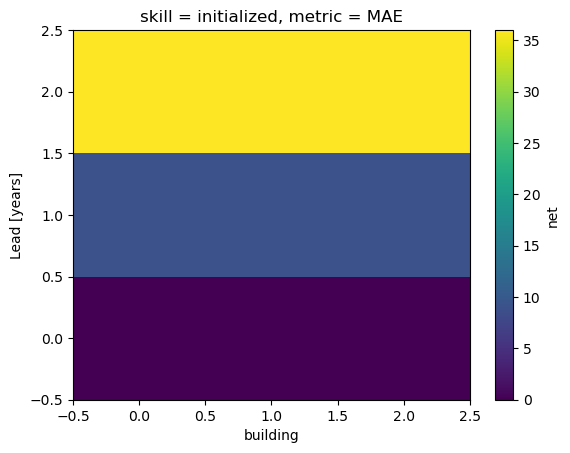

In [176]:
metric = 'mae'
ens.verify(metric='mse', comparison='e2o', dim='init', alignment='same_inits').assign_coords(metric=metric.upper()).net.plot()

In [178]:
# unpivot the lead time columns
scens = pd.melt(scens, id_vars=['init', 'member', 'building'], var_name='lead', value_name='net')
scens['lead'] = scens['lead'].str.replace('+', '').str.replace('h', '').astype(int)

xrds = scens.set_index(['init', 'member', 'building', 'lead']).to_xarray()

# add units to the lead time dimension
xrds['lead'].attrs['units'] = 'years'

/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_15087/1408580479.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  scens['lead'] = scens['lead'].str.replace('+', '').str.replace('h', '').astype(int)


In [179]:
xobs = reals.set_index(['time', 'building']).to_xarray()

In [180]:
ens = climpred.HindcastEnsemble(xrds)

/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:124: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(time_index, pd.Float64Index) | isinstance(
/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:125: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  time_index, pd.Int64Index
/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:128: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


In [181]:
ens = ens.add_observations(xobs)

/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:124: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(time_index, pd.Float64Index) | isinstance(
/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:125: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  time_index, pd.Int64Index
/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:128: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


In [210]:
metric = 'mae'
ens_mse = ens.verify(metric='mse', comparison='e2o', dim='init', alignment='same_inits', reference='persistence').assign_coords(metric=metric.upper())

KeyboardInterrupt: 

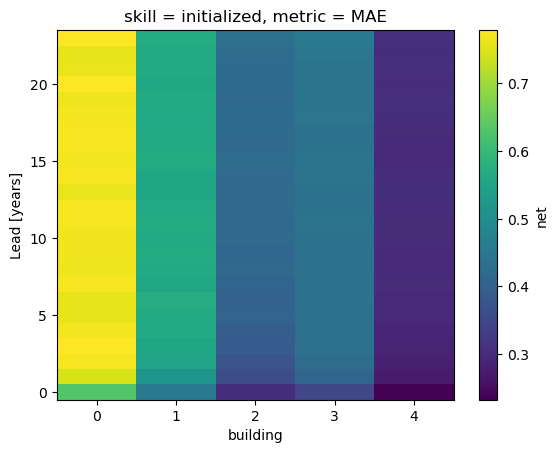

In [183]:
ens_mse['net'].plot()

In [193]:
metric = 'acc'
ens_acc = ens.verify(metric='acc', comparison='e2o', dim='init', alignment='same_inits').assign_coords(metric=metric.upper())

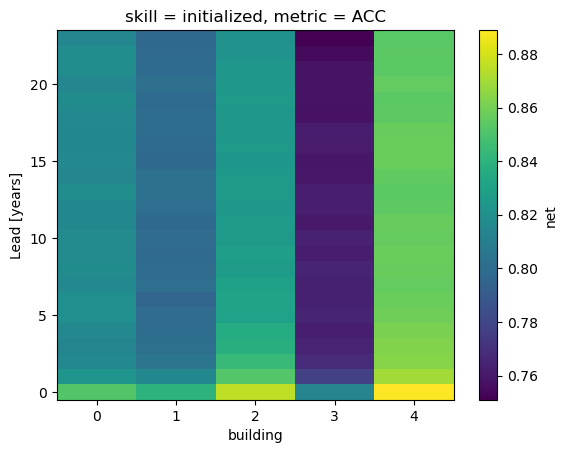

In [194]:
ens_acc['net'].plot()

In [198]:
# take unique scenario numbers if scens and get a list of lists with unique combinations of 5 that exist
scens_unique = scens['member'].unique()
scens_unique = scens_unique.tolist()
# get combinations of 5
scens_combinations = list(itertools.combinations(scens_unique, 5))
temp_scens = scens.loc[scens['member'].isin(scens_combinations[0])]
temp_xrds = temp_scens.set_index(['init', 'member', 'building', 'lead']).to_xarray()
temp_xrds['lead'].attrs['units'] = 'years'
temp_xobs = reals.set_index(['time', 'building']).to_xarray()
temp_ens = climpred.HindcastEnsemble(temp_xrds)
temp_ens = temp_ens.add_observations(temp_xobs)

/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:124: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(time_index, pd.Float64Index) | isinstance(
/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:125: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  time_index, pd.Int64Index
/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:128: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(
/Users/evgenygenov/miniforge3/envs/citylearn/lib/python3.9/site-packages/climpred/utils.py:124: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a

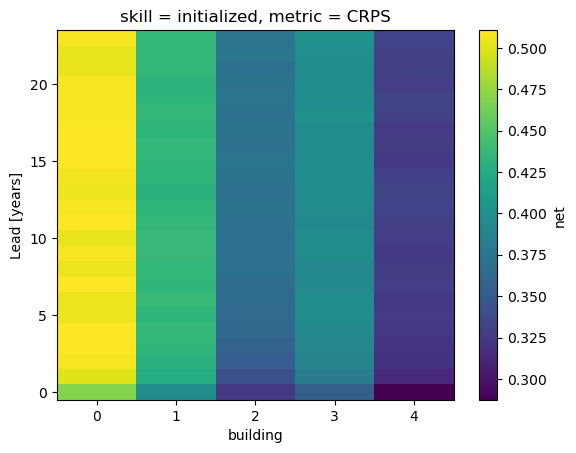

In [202]:
metric = 'crps'
crps_ens = temp_ens.verify(metric='crps', comparison='m2o', dim=['member', 'init'], alignment='same_inits').assign_coords(metric=metric.upper())
crps_ens['net'].plot()

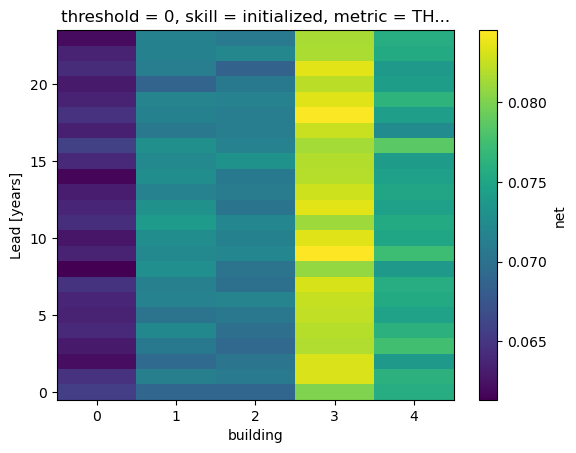

In [204]:
metric = 'threshold_brier_score'
brier_ens = temp_ens.verify(metric='threshold_brier_score', comparison='m2o', dim=['member', 'init'], alignment='same_inits', threshold=0).assign_coords(metric=metric.upper())
brier_ens['net'].plot()

In [219]:
metric = 'mae'
ens_mse = temp_ens.verify(metric='mse', comparison='m2o', dim=['member','init', 'building'], alignment='same_inits', reference='persistence').assign_coords(metric=metric.upper())

In [230]:
xarray_dict = {}
metric_dict = {}

In [238]:
# turn a list into string of numbers
''.join(str(e) for e in scens_combinations[0])

'01234'

In [246]:
metric_file.close()


In [245]:
metrics = ['mae', 'rmse', 'acc', 'nrmse', 'nmae', 'smape', 'crps', 'crpss', 'crpss_es', 'threshold_brier_score', 'less']
# start a csv with metrics as columns
metric_file = open('metrics.csv', 'w+')
# metrics as columns
index = ['unique_id']
line = metrics
metric_file.write(','.join(index + line) + '\n')
# write the index of the scenario to the csv
line_start = ''.join(str(e) for e in scens_combinations[0])
metric_file.write(line_start + ',')
for metric in metrics:
    xarray_dict[metric] = temp_ens.verify(metric=metric, comparison='m2o', dim=['member','init', 'building'], alignment='same_inits').assign_coords(metric=metric.upper())
    metric_dict[metric] = float(xarray_dict[metric]['net'].mean().values)
    metric_file.write(str(metric_dict[metric]) + ',')
metric_file.write('\n')
metric_file.close()
# write the metric values to the csv

KeyboardInterrupt: 

In [234]:
metric_dict['mae'] = float(ens_mse['net'].mean().values)

In [236]:
# take the metric_dict and make a dataframe
metric_df = pd.DataFrame.from_dict(metric_dict, orient='index', columns=['value'])
metric_df['metric'] = metric_df.index
# save to 
metric_df

,value,metric
mae,1.640191,mae


In [209]:

def __compute_anomalies(a, b, weights, axis, skipna):
    sumfunc, meanfunc = _get_numpy_funcs(skipna)
    # Only do weighted sums if there are weights. Cannot have a
    # single generic function with weights of all ones, because
    # the denominator gets inflated when there are masked regions.
    if weights is not None:
        with suppress_warnings("invalid value encountered in true_divide"):
            ma = sumfunc(a * weights, axis=axis) / sumfunc(weights, axis=axis)
            mb = sumfunc(b * weights, axis=axis) / sumfunc(weights, axis=axis)
    else:
        with suppress_warnings("Mean of empty slice"):
            ma = meanfunc(a, axis=axis)
            mb = meanfunc(b, axis=axis)
    am, bm = a - ma, b - mb
    return am, bm

# smoothness
def calculate_cv_standard_variation(
    forecast: xr.Dataset,
    verif: xr.Dataset,
    dim: dimType = None,
    **metric_kwargs: metric_kwargsType,
) -> xr.Dataset:

    fm = __compute_anomalies(forecast, verif, weights=None, axis=dim, **metric_kwargs)
    diff = am[0:-1] - am[1::]

    smoothness = np.std(diff) - abs(np.mean(diff))

    return smoothness